# MWC21 Hackaton

Barcelona Digital Talent nos plantea el reto de realizar una plataforma que evalúe algoritmos predictivos. El objetivo de este notebook es desarrollar un modelo predictivo. Este modelo debe ser capaz de predecir los ingresos dados los gastos en distintas redes sociales (Facebook, Instagram, Twitter, Discord...)

Se trata de un problema de regresión. El objetivo es encontrar un modelo que permita obtener el Error Medio Cuadrático (MSE) menor.

$$MSE = \frac{1}{N} \sum_i^N (y_i - \hat{y}_i)^2$$

donde $y_i$ es el target y $\hat{y}_i$ son las predicciones realizadas por el algoritmo. 
 
# Tabla de Contenidos <a class="anchor" id="0"></a>

1. [Data Understanding](#1)
2. [Data Cleaning](#2)
3. [Model selection](#3)
4. [Test prediction](#4) 
5. [Model interpretation](#5)

##

**Importamos librerías y dataset**

In [213]:
!pip install optuna

In [214]:
import pandas as pd
import numpy as np
import optuna

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Data preparation
from sklearn.model_selection import train_test_split, cross_val_score

# Regressor model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Metrics
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import r2_score


In [215]:
#Import train dataset
train = pd.read_csv('https://raw.githubusercontent.com/nuwe-io/bdtHackathon_final/main/Train.csv')
train.head()

,Instagram,Facebook,Twitter,Linkedin,Discord,Twitch,Ingresos
0,11.257702,2.943174,6.803809,15.873606,5.545977,21.238601,269.800741
1,9.304230,2.709958,5.095496,13.467107,5.900347,18.869122,86.752487
2,NaN,4.936659,6.173092,14.461141,6.763816,22.107658,348.569975
3,9.423370,4.507282,7.762059,15.635129,7.707726,19.378033,415.976620
4,NaN,5.258533,5.760111,13.585080,6.574550,22.045628,346.167361


## Data Understanding <a class="anchor" id="1"></a>

[Tabla de Contenidos](#0)

En este apartado se realizará un Exploratory Data Analysis donde se pretende obtener la relación entre las variables predictoras entre ellas y con el target que en este caso es *Ingresos*.

Existen 6 variables predictoras (donde se indican los gastos en cada una de las redes sociales):

- Instagram  
- Facebook 
- Twitter    
- Linkedin 
- Discord 
- Twitch

In [216]:
#Let's examine the main information of this dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Instagram  1985 non-null   float64
 1   Facebook   1971 non-null   float64
 2   Twitter    1956 non-null   float64
 3   Linkedin   1982 non-null   float64
 4   Discord    2000 non-null   float64
 5   Twitch     2010 non-null   float64
 6   Ingresos   2010 non-null   float64
dtypes: float64(7)
memory usage: 110.0 KB


Como se puede observar en la siguiente tabla los gastos más altos se producen en Twitch 

In [217]:
train.describe()

,Instagram,Facebook,Twitter,Linkedin,Discord,Twitch,Ingresos
count,1985.000000,1971.000000,1956.000000,1982.000000,2000.000000,2010.000000,2010.000000
mean,9.971020,4.075464,6.706138,14.960127,7.033877,20.973706,316.573369
std,1.000713,1.012235,1.009279,0.981687,1.018381,0.994449,104.069490
min,6.796837,0.572794,2.673021,11.290172,3.387479,17.660218,-46.952791
25%,9.325907,3.397380,5.986793,14.304720,6.354149,20.308463,244.088089
50%,9.961637,4.074588,6.717924,14.958475,7.056824,20.970154,316.368632
75%,10.608849,4.745205,7.408070,15.648404,7.737820,21.629410,387.564328
max,13.492470,7.205183,10.001590,18.670235,10.682078,24.323364,652.044392


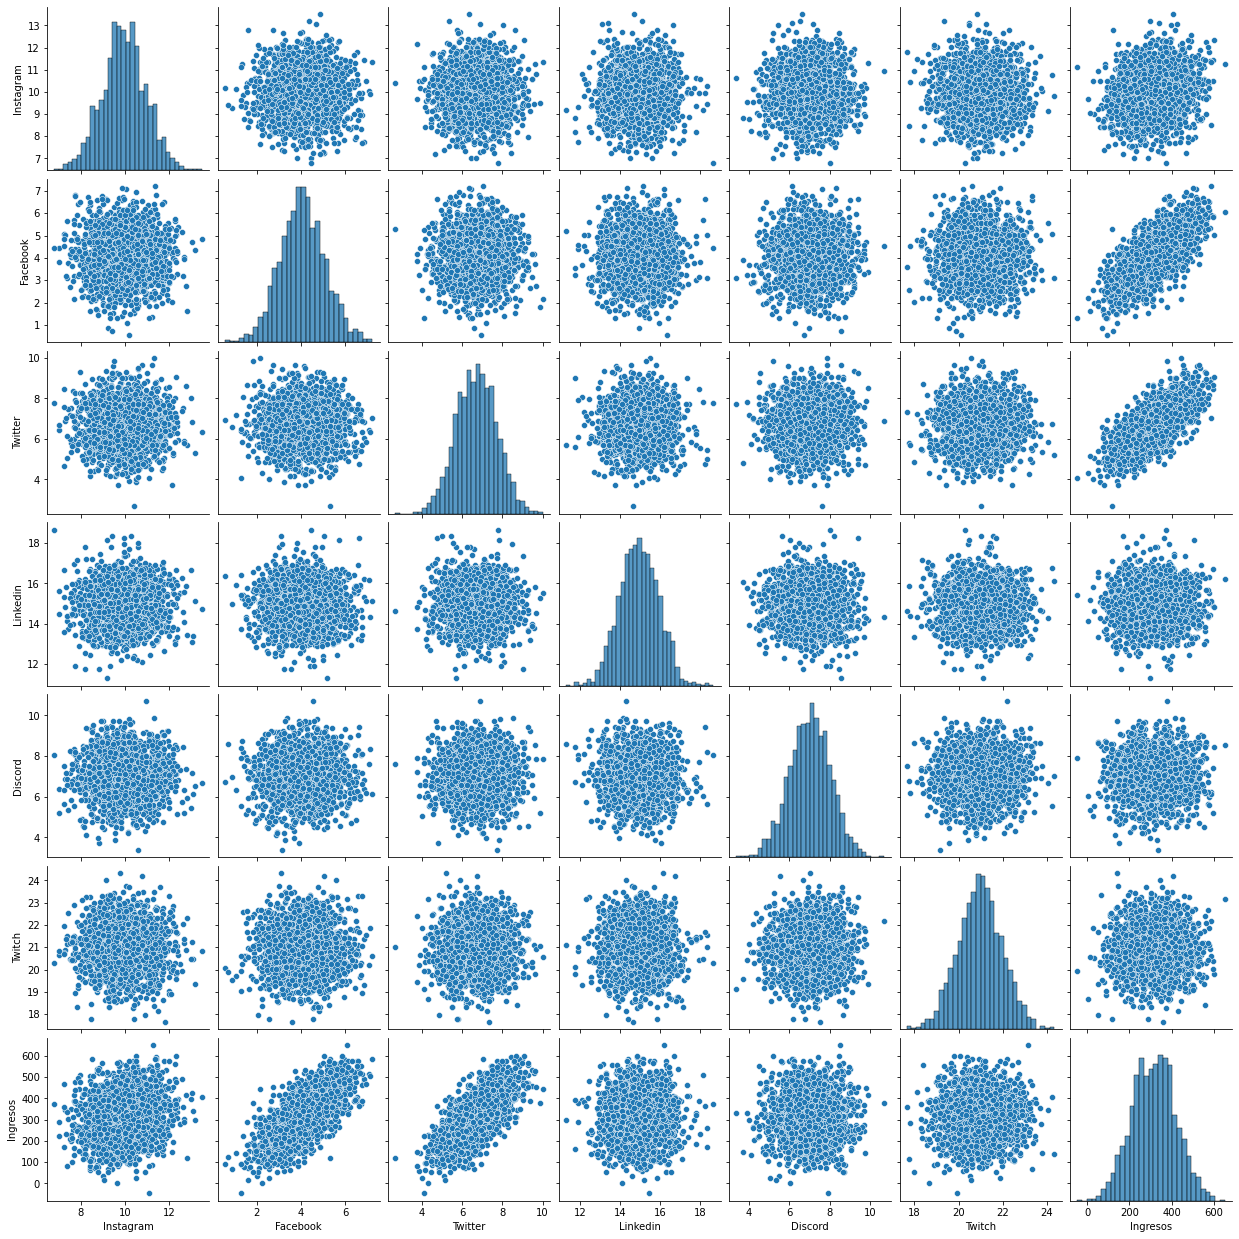

In [218]:
sns.pairplot(train)

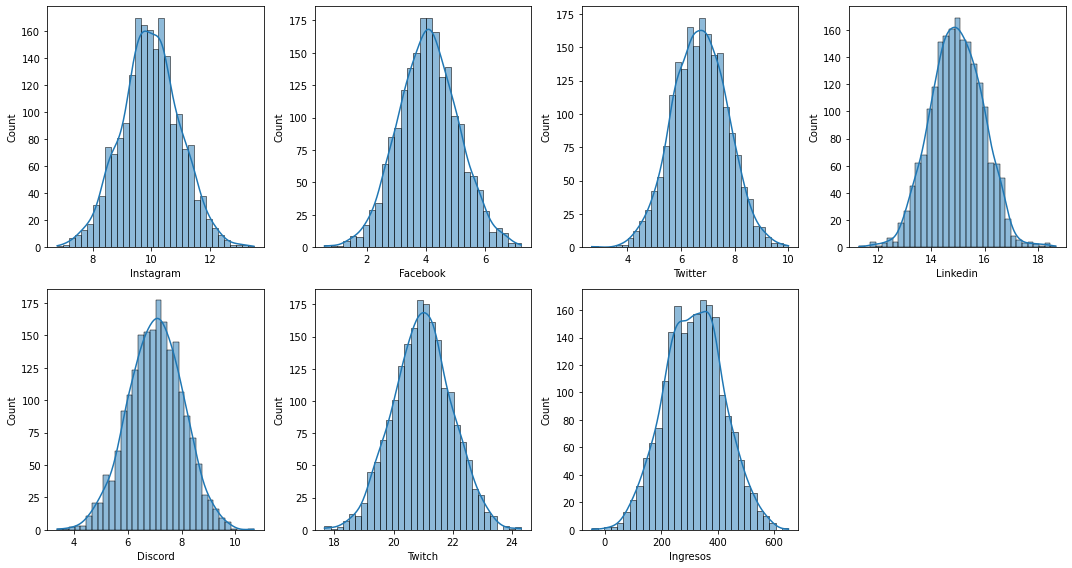

In [219]:
#View each variable in a histogram
fig, axs = plt.subplots(2,4, figsize = (15,8))
plt1 = sns.histplot(x=train['Instagram'], kde=True, ax = axs[0,0])
plt2 = sns.histplot(x=train['Facebook'], kde=True, ax = axs[0,1])
plt3 = sns.histplot(x=train['Twitter'], kde=True, ax = axs[0,2])
plt1 = sns.histplot(x=train['Linkedin'], kde=True, ax = axs[0,3])
plt2 = sns.histplot(x=train['Discord'], kde=True, ax = axs[1,0])
plt3 = sns.histplot(x=train['Twitch'], kde=True, ax = axs[1,1])
plt1 = sns.histplot(x=train['Ingresos'], kde=True, ax = axs[1,2])
fig.delaxes(axs[1][3])
plt.tight_layout()

Como se puede observar todas las variables están normalmente distribuidas, en barras se representa el histograma y en línea continua la curva KDE (Kernel Density estimator). 

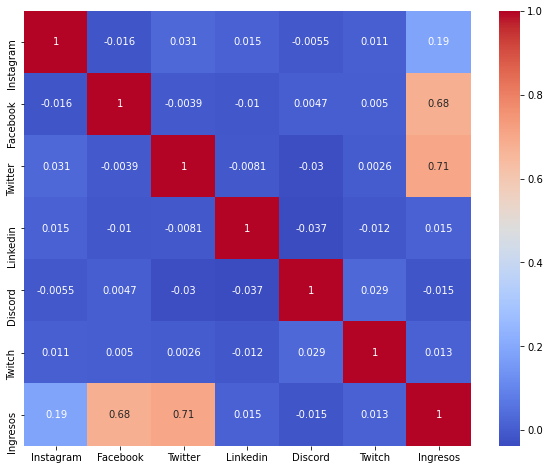

In [220]:
#Check correlation between variables, especially with the target variable
plt.figure(figsize = (10, 8))
sns.heatmap(train.corr(), annot = True, cmap="coolwarm")
plt.show()

En el heatmap anterior se puede observar la correlación lineal entre las diferentes variables. Destaca la alta correlación que existe entre Facebook y Twitter con la variable a predecir. Una correlación positiva indica que a mayores gastos, mayores ingresos, una correlación negativa indica lo contrario. 

## Data Cleaning <a class="anchor" id="2"></a>

[Tabla de Contenidos](#0)

En esta sección se realiza la limpieza de los datos. Ya sea limpieza de los valores nulos u outliers. 

En lo que respecta a los outliers, debido a los pocos datos se prefiere mantenerlos, además de que las muestras parecen estar correctamente normalmente distruibidas. 

En cambio para los valores nulos (NaN) se intentará trabajar con los registros con NaN para perder el mínimo de información posible. 

In [221]:
train = train[train["Ingresos"] >= 0]

In [222]:
train.isnull().sum()

Instagram    25
Facebook     39
Twitter      54
Linkedin     28
Discord      10
Twitch        0
Ingresos      0
dtype: int64

In [223]:
rows_with_nulls = train.isnull().sum(axis=1).sum()
rows_with_nulls

156

In [224]:
rows = train.shape[0]
rows

2009

In [225]:
print("{:2f}% of rows with nulls".format(rows_with_nulls/rows*100))

7.765057% of rows with nulls


Para el tratamiento de los nulos existen diversidad de opciones: imputar valor mediano, realizar una imputación por vecinos próximos KNNImputer... En nuestro caso, se decide adoptar la herramienta de 
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html">Iterative Imputer</a> (herramienta recomendada por uno de los mentores) para la imputación de nulos. 

Según su explicación en sklearn: *Multivariate imputer that estimates each feature from all the others. A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.*



In [226]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#train.dropna(inplace=True)

imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(train)

IterativeImputer(random_state=42)
train = pd.DataFrame(imp_mean.transform(train), columns=train.columns, index=train.index)

## Model selection <a class="anchor" id="3"></a>

[Tabla de Contenidos](#0)

Una vez limpios los datos, se procede a escoger el algoritmo de Machine Learning que mejor score da.

En este caso dada la poca cantidad de datos se prefiere realizar un KFold Cross Validation, en frente de un simple Random Holdout. De esta manera, el modelo verá diferentes datasets y la métrica que se dará será más precisa a la realidad. 

Se testean diferentes modelos desde modelos geométricos como regresión lineales ya sea normal, Lasso o Ridge, como Support Vector Machines y KNeighbors o ensemble de modelos de árbol de decisión como RandomForest. 

In [227]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]
X_train.shape, y_train.shape

((2009, 6), (2009,))

In [228]:
def objective(trial):
  regressor_name = trial.suggest_categorical('regressor', ['LinearRegression', 'Lasso', 'Ridge', 'RandomForestRegressor',
                                                           'GradientBoostingRegressor', 'SVR', 'KNeighborsRegressor'])
  
  if regressor_name == 'LinearRegression':
    regressor = LinearRegression()
  elif regressor_name == 'Lasso':
    regressor = Lasso()
  elif regressor_name == 'Ridge':
    regressor = Ridge()
  elif regressor_name == 'RandomForestRegressor':
    regressor = RandomForestRegressor()
  elif regressor_name == 'GradientBoostingRegressor':
    regressor = GradientBoostingRegressor()
  elif regressor_name == 'SVR':
    regressor = SVR()
  elif regressor_name == 'KNeighborsRegressor':
    regressor = KNeighborsRegressor() 
  
  score = cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  return score.mean()

study = optuna.create_study(direction="maximize")                               
study.optimize(objective, n_trials=20, show_progress_bar=True)                  
print("Best Value: ", study.best_trial.value)
print("Best Parameters: ")
for key, value in study.best_trial.params.items():
  print(f" {key}: {value}")

[I 2021-06-29 14:12:41,297] A new study created in memory with name: no-name-94f878d9-f9a2-46f7-bfb3-7a1028acf027
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



[I 2021-06-29 14:12:41,433] Trial 0 finished with value: -0.004222191270989418 and parameters: {'regressor': 'Ridge'}. Best is trial 0 with value: -0.004222191270989418.
[I 2021-06-29 14:12:45,065] Trial 1 finished with value: -176.94935669962288 and parameters: {'regressor': 'RandomForestRegressor'}. Best is trial 0 with value: -0.004222191270989418.
[I 2021-06-29 14:12:45,117] Trial 2 finished with value: -4.048882700263894 and parameters: {'regressor': 'Lasso'}. Best is trial 0 with value: -0.004222191270989418.
[I 2021-06-29 14:12:46,063] Trial 3 finished with value: -8430.812460168254 and parameters: {'regressor': 'SVR'}. Best is trial 0 with value: -0.004222191270989418.
[I 2021-06-29 14:12:47,739] Trial 4 finished with value: -83.37185107600028 and parameters: {'regressor': 'GradientBoostingRegressor'}. Best is trial 0 with value: -0.004222191270989418.
[I 2021-06-29 14:12:51,214] Trial 5 finished with value: -174.1671699001236 and parameters: {'regressor': 'RandomForestRegresso

Tras probar varios modelos el modelo con mejor es la Regresión Lineal, con un error minúsculo. 

El valor de MSE medio en Cross Validation es de 9.22787579 $ \cdot 10^{-05}$.

## Test Prediction <a class="anchor" id="4"></a>

[Tabla de Contenidos](#0)

Finalmente, se utiliza el modelo para predecir en test. En este caso target y variables predictoras vienen separadas. Y el error obtenido es de la misma magnitud por lo que se puede afirmar que no existe overfitting. 

In [229]:
X_test = pd.read_csv('https://raw.githubusercontent.com/nuwe-io/bdtHackathon_final/main/Test_predictors.csv')
X_test.head()

,Instagram,Facebook,Twitter,Linkedin,Discord,Twitch
0,10.527703,4.960205,6.479963,15.498262,6.955613,20.025227
1,8.850377,2.512854,7.353186,14.727766,7.401905,18.968000
2,9.544153,3.244153,7.148553,15.424961,6.664496,21.347135
3,8.376256,3.885037,7.901298,14.386792,6.638287,21.202560
4,9.730666,4.226696,6.541970,14.752687,6.498743,19.926721


In [230]:
regressor = LinearRegression()
regressor.fit(X=X_train, y=y_train)
pred_test = regressor.predict(X_test)

In [231]:
regressor.intercept_

-683.1676938301869

In [232]:
y_test = pd.read_csv('https://raw.githubusercontent.com/nuwe-io/bdtHackathon_final/main/Test_target.csv')
y_test.head()

,Ingresos
0,374.930338
1,231.783656
2,283.456227
3,359.268055
4,310.711226


In [233]:
mse_test = MSE(y_test, pred_test)
r2_test = r2_score(y_test, pred_test)
print('MSE Test:', mse_test)
print('R2 Test: ', r2_test)

MSE Test: 9.121878175184184e-05
R2 Test:  0.9999999919779641


In [234]:
pred_test_df = pd.Series(pred_test, name='Ingresos')
pred_test_df.head()

0    374.940333
1    231.781917
2    283.458696
3    359.277462
4    310.721515
Name: Ingresos, dtype: float64

In [235]:
pred_test_df.to_json('predictions_test.json', orient='split')

## Model interpretation <a class="anchor" id="5"></a>

[Tabla de Contenidos](#0)

Tras haber obtenido el modelo, se interpreta el modelo. ¿Qué variables influyen más en el modelo? ¿Qué variables tienen mayor peso?

Esta parte es interesante para negocio, para poder decidir en qué Red Social es más rentable invertir.


In [236]:
coefficients = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(regressor.coef_))], axis = 1)
coefficients.columns = ['Red Social', 'Coeficiente']

coefficients.sort_values(by='Coeficiente', ascending=False).head(10)

,Red Social,Coeficiente
2,Twitter,72.603609
1,Facebook,70.942376
0,Instagram,18.385670
3,Linkedin,2.722596
5,Twitch,-0.000073
4,Discord,-0.000341


In [237]:
test_data = pd.DataFrame()
test_data['Ingresos Pred.'] = pred_test_df
test_data['Ingresos True'] = y_test['Ingresos']
test_data['Gastos Totales'] = X_test.sum(axis=1)
test_data.head()

,Ingresos Pred.,Ingresos True,Gastos Totales
0,374.940333,374.930338,64.446974
1,231.781917,231.783656,59.814088
2,283.458696,283.456227,63.373451
3,359.277462,359.268055,62.390229
4,310.721515,310.711226,61.677481


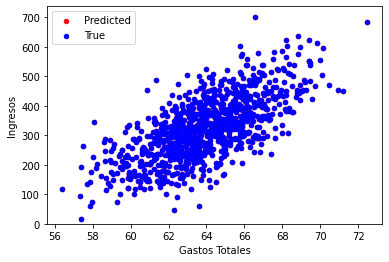

In [238]:
ax = plt.gca()
test_data.plot(kind='scatter', x='Gastos Totales', y='Ingresos Pred.', color='r', ax=ax, label='Predicted')    
test_data.plot(kind='scatter', x='Gastos Totales', y='Ingresos True', color='b', ax=ax, label='True')   
plt.ylabel('Ingresos')
plt.ylim(bottom=0)
plt.legend()
plt.show()

Nótese que este modelo tan sólo es válido para un rango de gastos totales, existe un valor de gastos mínimos para los cuáles este modelo es válido. 

In [239]:
X_test.columns

gastos_totales = 65

tests = pd.DataFrame(np.array([50, 10, 10, 10, 10, 10])).T

tests = tests.append( pd.DataFrame([10, 50, 10, 10, 10, 10]).T, ignore_index=True)
tests = tests.append( pd.DataFrame([10, 10, 50, 10, 10, 10]).T, ignore_index=True)
tests = tests.append( pd.DataFrame([10, 10, 10, 50, 10, 10]).T, ignore_index=True)
tests = tests.append( pd.DataFrame([10, 10, 10, 10, 50, 10]).T, ignore_index=True)
tests = tests.append( pd.DataFrame([10, 10, 10, 10, 10, 50]).T, ignore_index=True)

tests.columns = X_test.columns

In [240]:
tests_pred = tests.multiply(gastos_totales/100)

tests['Predictions'] = regressor.predict(tests_pred)

In [241]:
tests

,Instagram,Facebook,Twitter,Linkedin,Discord,Twitch,Predictions
0,50,10,10,10,10,10,865.109660
1,10,50,10,10,10,10,2231.584009
2,10,10,50,10,10,10,2274.776076
3,10,10,10,50,10,10,457.869745
4,10,10,10,10,50,10,387.073369
5,10,10,10,10,10,50,387.080332
